In [1]:
import os
import yaml
import torch
import argparse
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer, seed_everything
from experiment import VAEXperiment
from dataset import VAEDataset
from models import vae_models

# Argument parser 설정
parser = argparse.ArgumentParser(description='VAE Model Prediction')
parser.add_argument('--config', '-c',
                    dest="filename",
                    metavar='FILE',
                    help='path to the config file',
                    default='configs/vae.yaml')
args = parser.parse_args([])

# 설정 파일 로드
with open(args.filename, 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

# 재현성 설정
seed_everything(config['exp_params']['manual_seed'], True)

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 모듈 설정
data = VAEDataset(**config["data_params"], pin_memory=config['trainer_params'].get('devices', 0) != 0)
data.setup()

# 모델 초기화 및 체크포인트 로드
model = vae_models[config['model_params']['name']](**config['model_params'])
checkpoint_path = os.path.join(config['logging_params']['save_dir'], 
                               config['logging_params']['name'], 
                               "version_1", "checkpoints", "last.ckpt")

experiment = VAEXperiment.load_from_checkpoint(
    checkpoint_path=checkpoint_path,
    vae_model=model,
    params=config['exp_params']
).to(device)

# 테스트 데이터셋에서 예시 이미지를 가져와 예측 수행
def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        example_images, _ = next(iter(dataloader))
        example_images = example_images.to(device)
        reconstructions, _, mu, var = model(example_images)
    return example_images, reconstructions
        
def display_images(images, title):
    images = images.cpu().numpy()  # 텐서를 넘파이로 변환
    num_images = len(images)
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols  # 5개씩 한 행에 배치
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    fig.suptitle(title, fontsize=16)
    
    for i, image in enumerate(images):
        row, col = divmod(i, num_cols)
        axes[row, col].imshow(image.transpose(1, 2, 0))
        axes[row, col].axis('off')
    
    # 빈 공간을 비활성화
    for j in range(i + 1, num_rows * num_cols):
        row, col = divmod(j, num_cols)
        axes[row, col].axis('off')
        
    plt.show()

Seed set to 1265


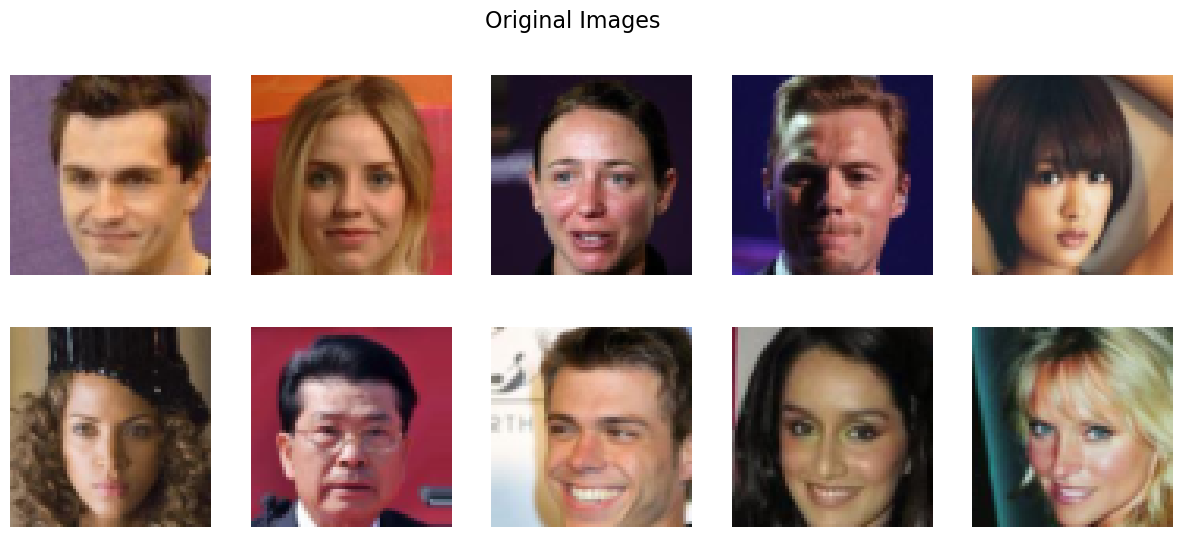

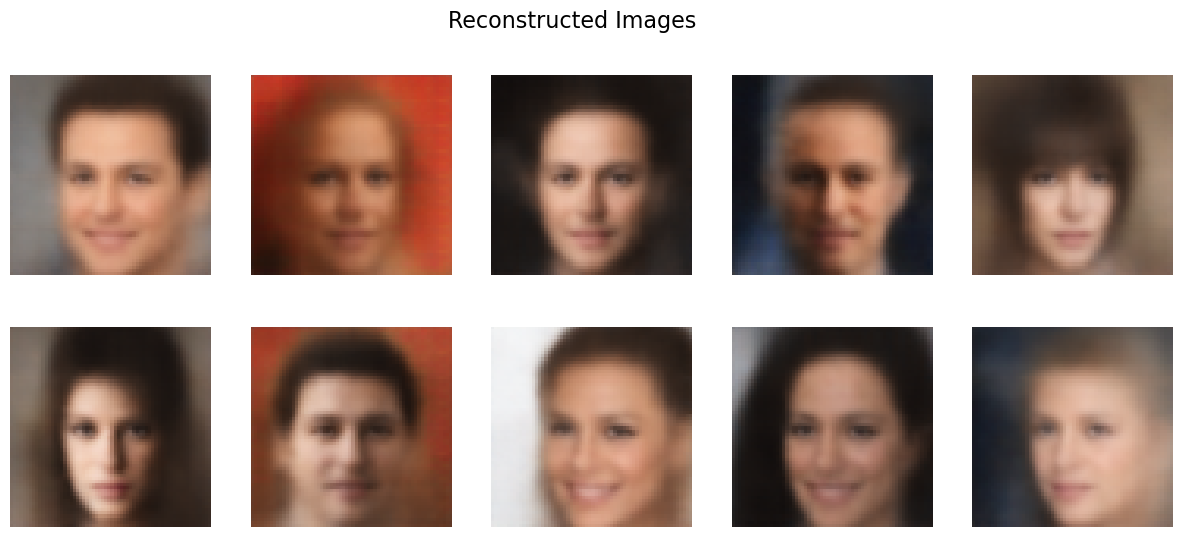

In [ ]:
# 예측 및 이미지 시각화 수행
example_images, reconstructions = predict(experiment, data.test_dataloader())
num_images = 10
display_images(example_images[:num_images], title="Original Images")
display_images(reconstructions[:num_images], title="Reconstructed Images")

In [ ]:

model.eval()
with torch.no_grad():
    example_images, _ = next(iter(dataloader))
    example_images = example_images.to(device)
    reconstructions, _, mu, var = model(example_images)
example_images, reconstructions = predict(experiment, data.test_dataloader())

In [5]:
def extract_z_values(model, data_loader, device):
    model.eval()  # 모델을 평가 모드로 전환
    all_z_mean = []
    all_z_log_var = []

    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            _, _, mu, var = model(images)
            all_z_mean.append(mu.cpu())  # z_mean을 CPU로 이동 후 저장
            all_z_log_var.append(var.cpu())  # z_log_var를 CPU로 이동 후 저장

    # 리스트를 하나의 텐서로 결합
    all_z_mean = torch.cat(all_z_mean, dim=0)
    all_z_log_var = torch.cat(all_z_log_var, dim=0)
    
    return all_z_mean, all_z_log_var

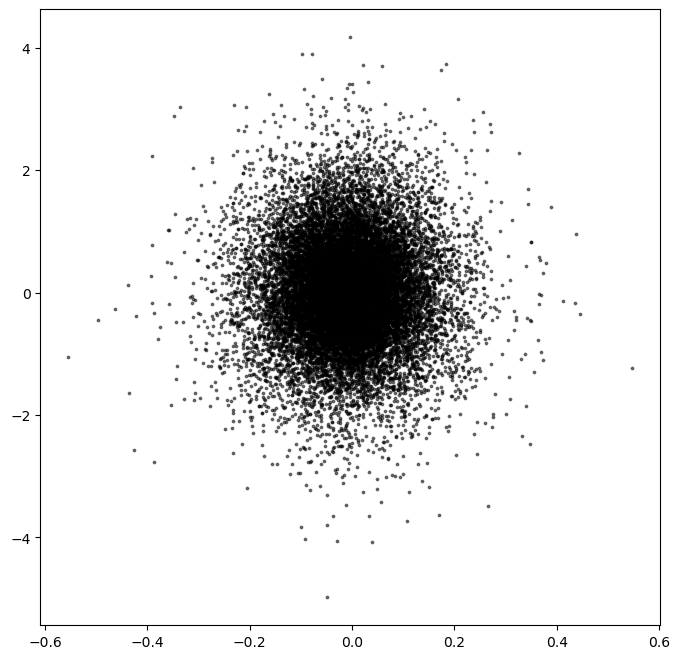

In [ ]:
# 모든 테스트 데이터에서 z_mean, z_log_var를 추출
all_z_mean, all_z_log_var = extract_z_values(experiment, data.test_dataloader(), device)

# 2D 공간에서 인코딩된 포인트 표시
figsize = 8

# GPU에 있는 텐서를 detach() 후 CPU로 이동, numpy로 변환
z = all_z_mean.detach().cpu().numpy()

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

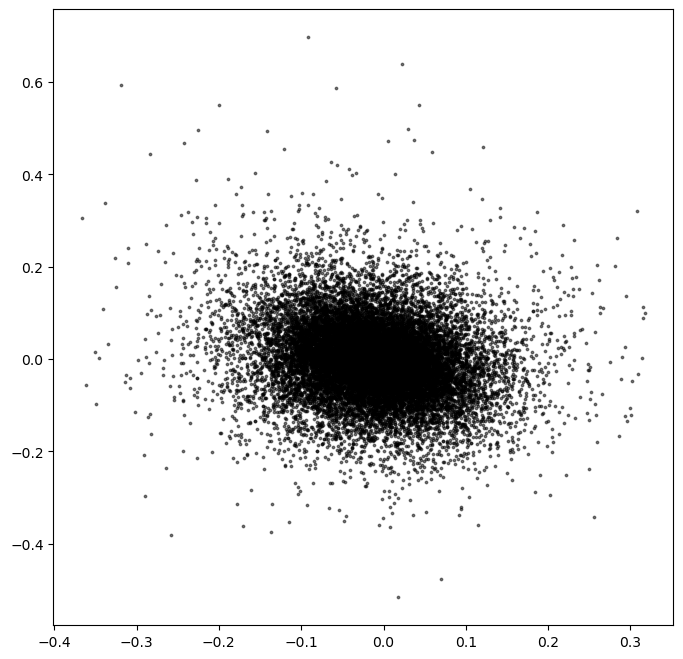

In [ ]:
# 모든 테스트 데이터에서 z_mean, z_log_var를 추출
all_z_mean, all_z_log_var = extract_z_values(experiment, data.test_dataloader(), device)

# 2D 공간에서 인코딩된 포인트 표시
figsize = 8

# GPU에 있는 텐서를 detach() 후 CPU로 이동, numpy로 변환
z = all_z_mean.detach().cpu().numpy()

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

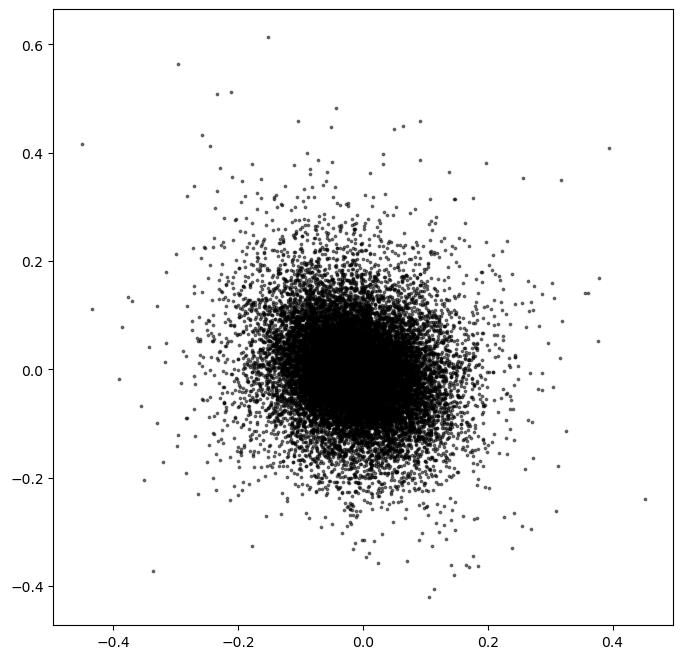

In [6]:
# 모든 테스트 데이터에서 z_mean, z_log_var를 추출
all_z_mean, all_z_log_var = extract_z_values(experiment, data.test_dataloader(), device)

# 2D 공간에서 인코딩된 포인트 표시
figsize = 8

# GPU에 있는 텐서를 detach() 후 CPU로 이동, numpy로 변환
z = all_z_mean.detach().cpu().numpy()

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()